In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10


os.makedirs('figs', exist_ok=True)

In [2]:

def load_scheduler_data(scheduler_name):
  
    results_file = f'data/Demo2_{scheduler_name}_results.csv'
    
    if not os.path.exists(results_file):
        print(f"Error: Can't find {results_file}")
        return None
    
    results_df = pd.read_csv(results_file)
    print(f"Loaded {scheduler_name}: {len(results_df)} points")
    
    return results_df

In [3]:

def plot_stability_analysis(results_df, scheduler_name):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    

    lambda_vals = results_df['Lambda'].values
    stable_mask = results_df['Stable'] == 'Yes'
    
    qps = results_df['QPS'].values
    rts_p95 = results_df['RTS_P95'].values
    

    ttft_avg = results_df['TTFT_Avg'].values
    tbt_avg = results_df['TBT_Avg'].values
    rts_avg = results_df['RTS_Avg'].values
    
    ttft_increase = (ttft_avg - ttft_avg[0]) / (ttft_avg[0] + 1e-9)
    tbt_increase = (tbt_avg - tbt_avg[0]) / (tbt_avg[0] + 1e-9)
    rts_increase = (rts_avg - rts_avg[0]) / (rts_avg[0] + 1e-9)
    

    ax = axes[0, 0]
    
    if np.any(stable_mask):
        ax.plot(lambda_vals[stable_mask], qps[stable_mask],
               'o-', color='green', linewidth=2, markersize=8, label='Stable')
    if np.any(~stable_mask):
        ax.plot(lambda_vals[~stable_mask], qps[~stable_mask],
               'x--', color='red', linewidth=2, markersize=10, label='Unstable')
    

    ax.plot(lambda_vals, lambda_vals, ':', color='gray', alpha=0.5, label='Ideal')
    

    stable_lambdas = lambda_vals[stable_mask]
    unstable_lambdas = lambda_vals[~stable_mask]
    
    if len(stable_lambdas) > 0 and len(unstable_lambdas) > 0:
        lambda_star = max(stable_lambdas)
        ax.axvline(lambda_star, color='orange', linestyle='--', linewidth=2,
                  label=f'λ*≈{lambda_star:.2f}')
    
    ax.set_xlabel('λ (queries/s)', fontsize=11)
    ax.set_ylabel('Throughput (qps)', fontsize=11)
    ax.set_title('Throughput vs Arrival Rate', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    

    ax = axes[0, 1]
    
    ax.plot(lambda_vals, ttft_increase, 'o-', label='TTFT', linewidth=2, markersize=6)
    ax.plot(lambda_vals, tbt_increase, 's-', label='TBT', linewidth=2, markersize=6)
    ax.plot(lambda_vals, rts_increase, '^-', label='RTS', linewidth=2, markersize=6)
    ax.axhline(0.10, color='orange', linestyle='--', alpha=0.5, label='Threshold (10%)')
    
    ax.set_xlabel('λ (queries/s)', fontsize=11)
    ax.set_ylabel('Relative Increase', fontsize=11)
    ax.set_title('Metric Growth Rate', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    

    ax = axes[1, 0]
    

    congestion_types = []
    for i in range(len(lambda_vals)):
        increases = {
            'TTFT': ttft_increase[i],
            'TBT': tbt_increase[i],
            'RTS': rts_increase[i]
        }
        if max(increases.values()) > 0.10:
            congestion_types.append(max(increases, key=increases.get))
        else:
            congestion_types.append('None')
    

    from collections import Counter
    counts = Counter(congestion_types)
    
    if counts:
        colors_map = {'TTFT': 'blue', 'TBT': 'orange', 'RTS': 'purple', 'None': 'green'}
        colors = [colors_map.get(k, 'gray') for k in counts.keys()]
        ax.bar(counts.keys(), counts.values(), color=colors)
    
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Congestion Type Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    

    ax = axes[1, 1]
    
    if np.any(stable_mask):
        ax.plot(lambda_vals[stable_mask], rts_p95[stable_mask],
               'o-', color='green', linewidth=2, markersize=8, label='Stable')
    if np.any(~stable_mask):
        ax.plot(lambda_vals[~stable_mask], rts_p95[~stable_mask],
               'x--', color='red', linewidth=2, markersize=10, label='Unstable')
    
    ax.set_xlabel('λ (queries/s)', fontsize=11)
    ax.set_ylabel('P95 RTS (s)', fontsize=11)
    ax.set_title('Tail Latency', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    

    plt.suptitle(f'Stability Boundary Analysis: Demo2_{scheduler_name}',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    

    filename = f'figs/Demo2_{scheduler_name}_stability_boundary.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Save: {filename}")
    plt.close(fig)  
    
    return fig

In [4]:

schedulers = ['decode_prioritizing', 'prefill_prioritizing', 'hybrid']

for scheduler in schedulers:
    print(f"\n{'='*80}")
    print(f"Process: {scheduler}")
    print('='*80)
    

    df = load_scheduler_data(scheduler)
    
    if df is not None:

        plot_stability_analysis(df, scheduler)
        print()


Process: decode_prioritizing
Loaded decode_prioritizing: 7 points
Save: figs/Demo2_decode_prioritizing_stability_boundary.png


Process: prefill_prioritizing
Loaded prefill_prioritizing: 8 points
Save: figs/Demo2_prefill_prioritizing_stability_boundary.png


Process: hybrid
Loaded hybrid: 8 points
Save: figs/Demo2_hybrid_stability_boundary.png



In [5]:

def plot_comparison():

    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    schedulers = ['decode_prioritizing', 'prefill_prioritizing', 'hybrid']
    colors = ['red', 'blue', 'green']
    labels = ['Decode-First', 'Prefill-First', 'Hybrid']
    

    ax = axes[0]
    for scheduler, color, label in zip(schedulers, colors, labels):
        df = load_scheduler_data(scheduler)
        if df is not None:
            lambda_vals = df['Lambda'].values
            qps = df['QPS'].values
            stable_mask = df['Stable'] == 'Yes'
            

            if np.any(stable_mask):
                ax.plot(lambda_vals[stable_mask], qps[stable_mask],
                       'o-', color=color, linewidth=2, markersize=6, label=label)

            if np.any(~stable_mask):
                ax.plot(lambda_vals[~stable_mask], qps[~stable_mask],
                       'x--', color=color, linewidth=2, markersize=8, alpha=0.5)
    

    max_lambda = 5.0
    ax.plot([0, max_lambda], [0, max_lambda], ':', color='gray', alpha=0.5, label='Ideal')
    
    ax.set_xlabel('λ (queries/s)', fontsize=11)
    ax.set_ylabel('Throughput (qps)', fontsize=11)
    ax.set_title('Throughput Comparison', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    

    ax = axes[1]
    lambda_stars = []
    conf_widths = []
    
    for scheduler in schedulers:
        df = load_scheduler_data(scheduler)
        if df is not None:
            stable_mask = df['Stable'] == 'Yes'
            stable_lambdas = df['Lambda'].values[stable_mask]
            unstable_lambdas = df['Lambda'].values[~stable_mask]
            
            if len(stable_lambdas) > 0 and len(unstable_lambdas) > 0:
                lambda_star = (max(stable_lambdas) + min(unstable_lambdas)) / 2
                conf_width = min(unstable_lambdas) - max(stable_lambdas)
            elif len(stable_lambdas) > 0:
                lambda_star = max(stable_lambdas)
                conf_width = 0
            else:
                lambda_star = 0
                conf_width = 0
            
            lambda_stars.append(lambda_star)
            conf_widths.append(conf_width / 2)
    
    x_pos = np.arange(len(labels))
    bars = ax.bar(x_pos, lambda_stars, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.errorbar(x_pos, lambda_stars, yerr=conf_widths, fmt='none', color='black', capsize=5, linewidth=2)
    

    for i, (val, err) in enumerate(zip(lambda_stars, conf_widths)):
        if err > 0:
            ax.text(i, val + err + 0.1, f'{val:.2f}±{err:.2f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax.text(i, val + 0.1, f'>{val:.2f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel('λ* (queries/s)', fontsize=11)
    ax.set_title('Stability Boundary Comparison', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Demo 2: Scheduler Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = 'figs/Demo2_comparison.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\nSave: {filename}")
    plt.close(fig)  

In [6]:

plot_comparison()

Loaded decode_prioritizing: 7 points
Loaded prefill_prioritizing: 8 points
Loaded hybrid: 8 points
Loaded decode_prioritizing: 7 points
Loaded prefill_prioritizing: 8 points
Loaded hybrid: 8 points

Save: figs/Demo2_comparison.png



decode_prioritizing:


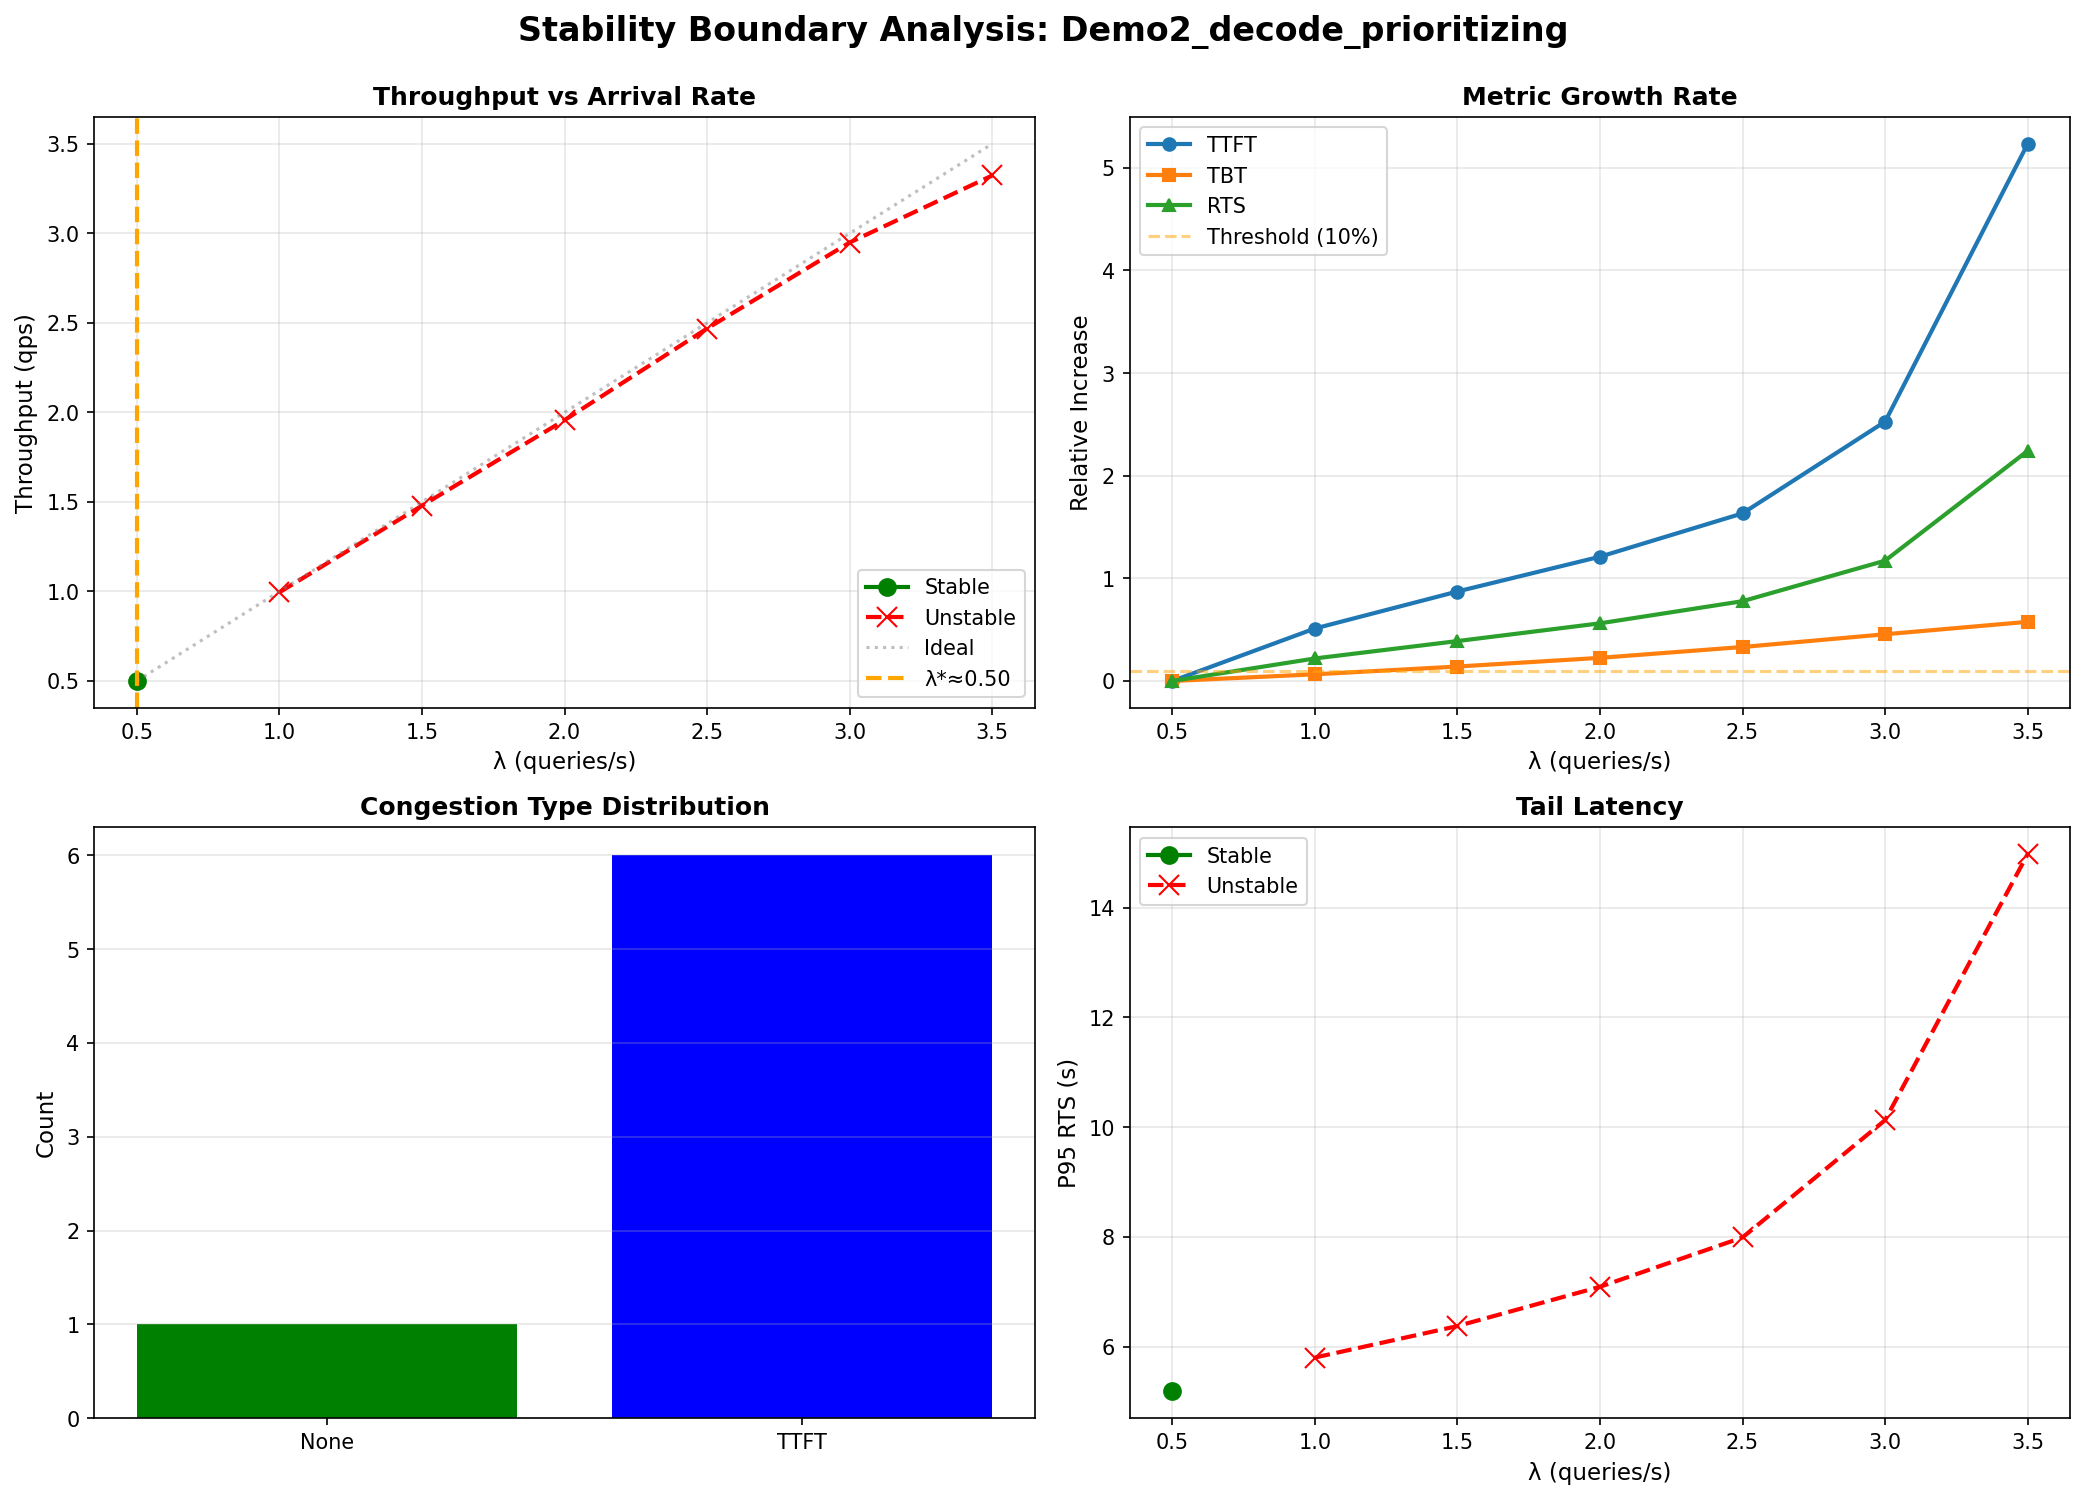


prefill_prioritizing:


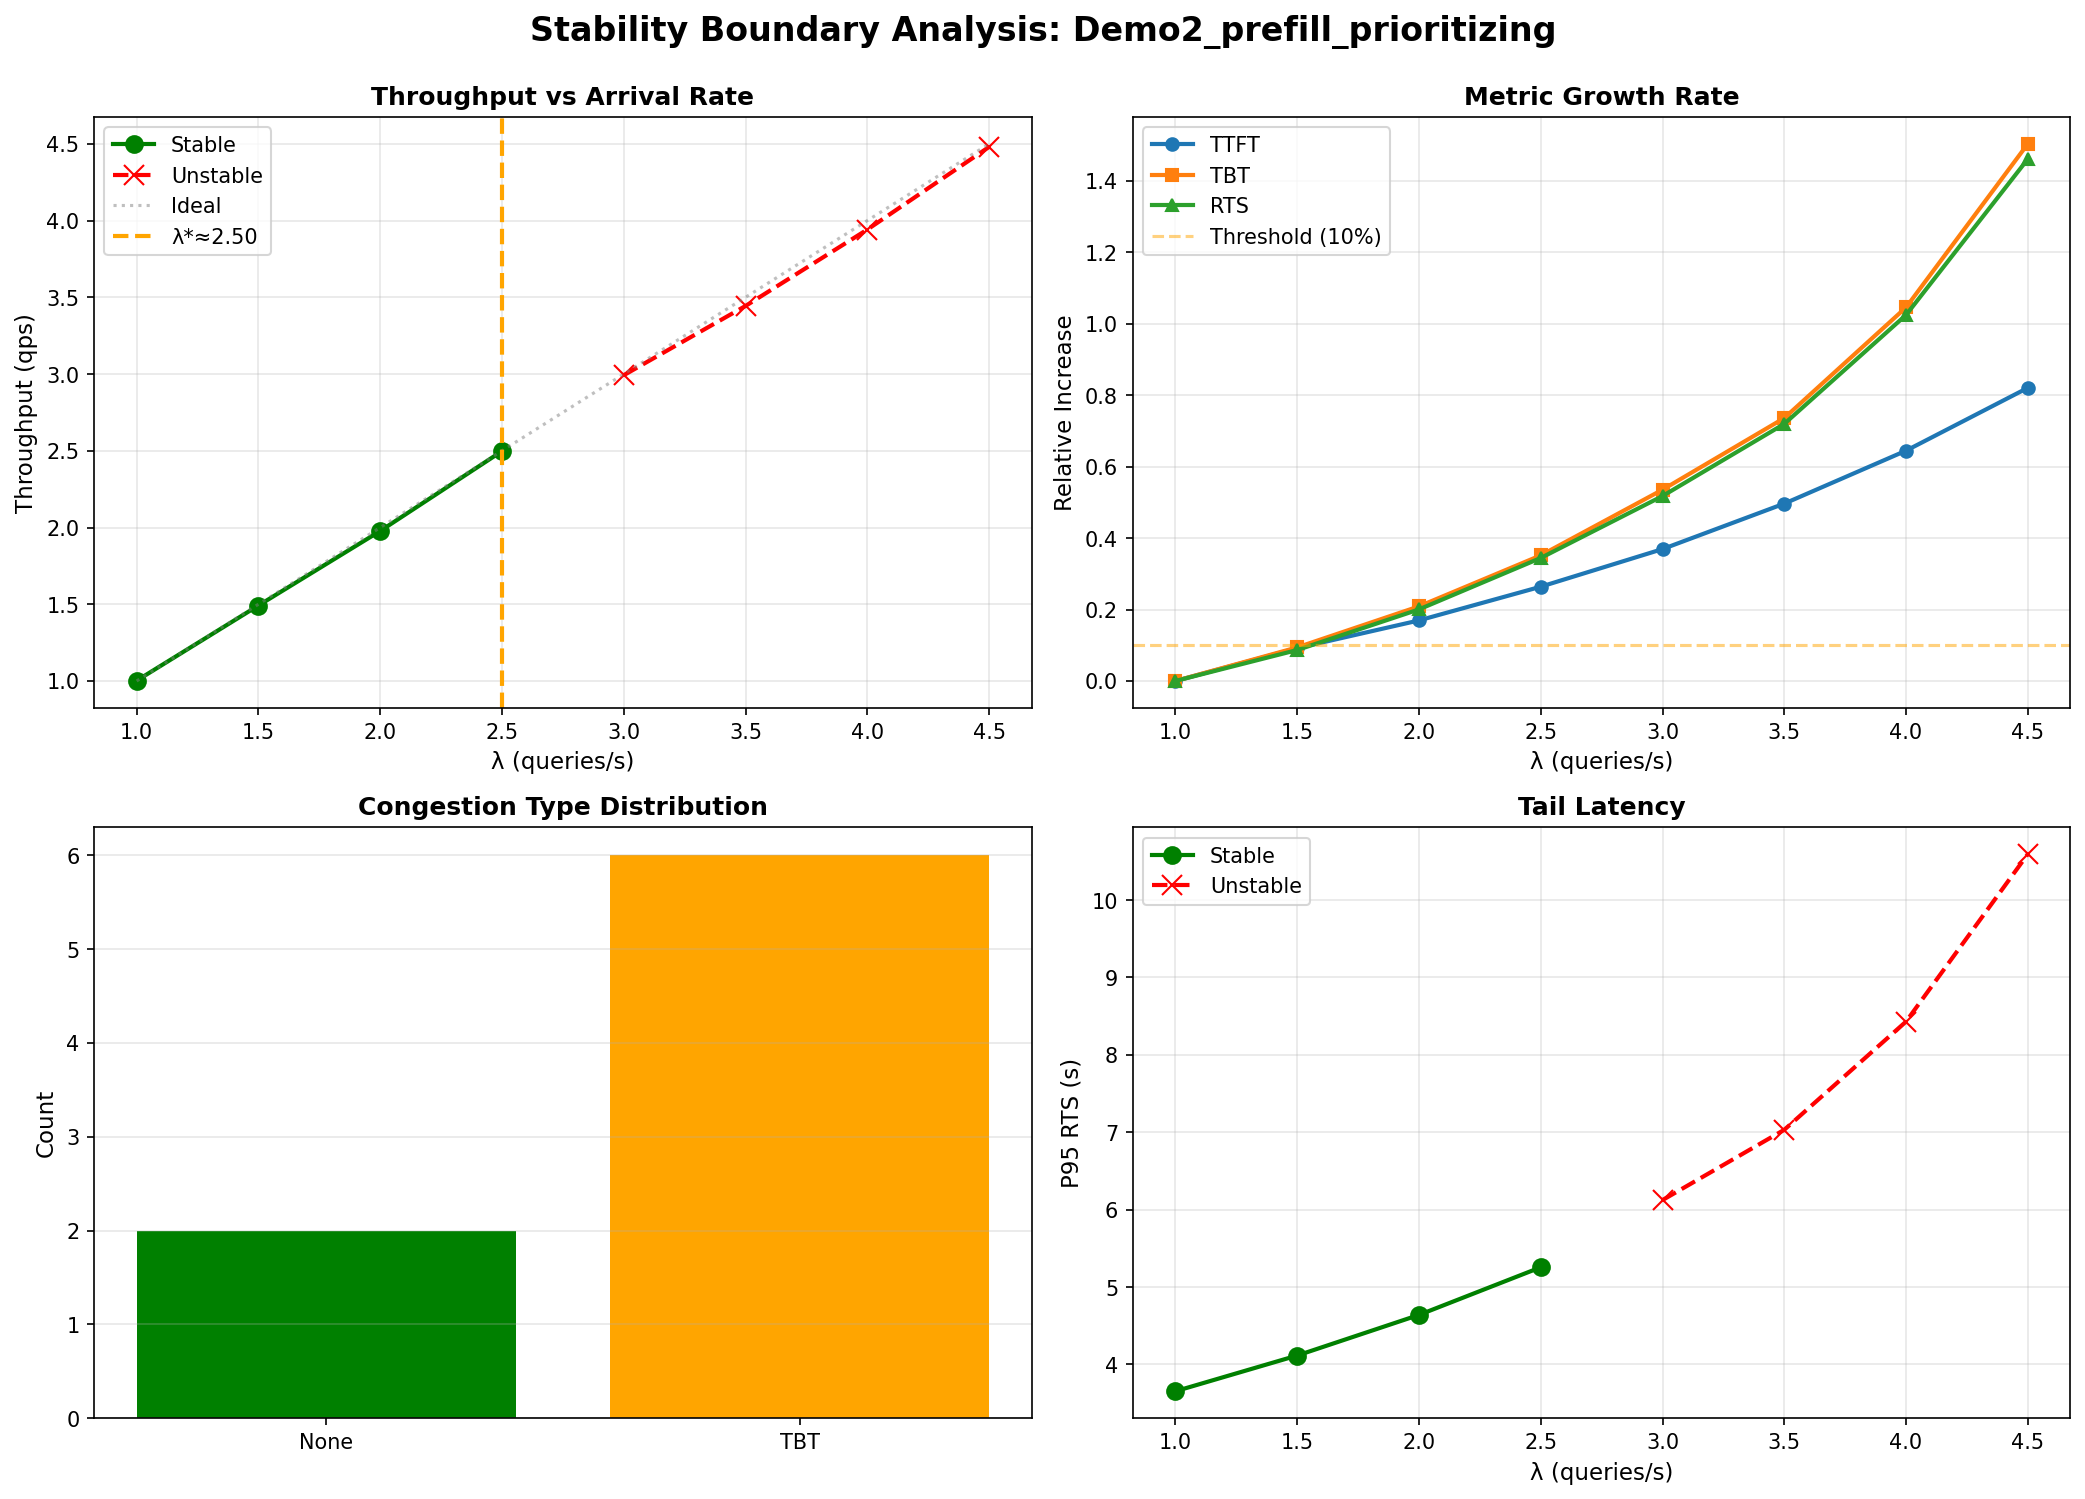


hybrid:


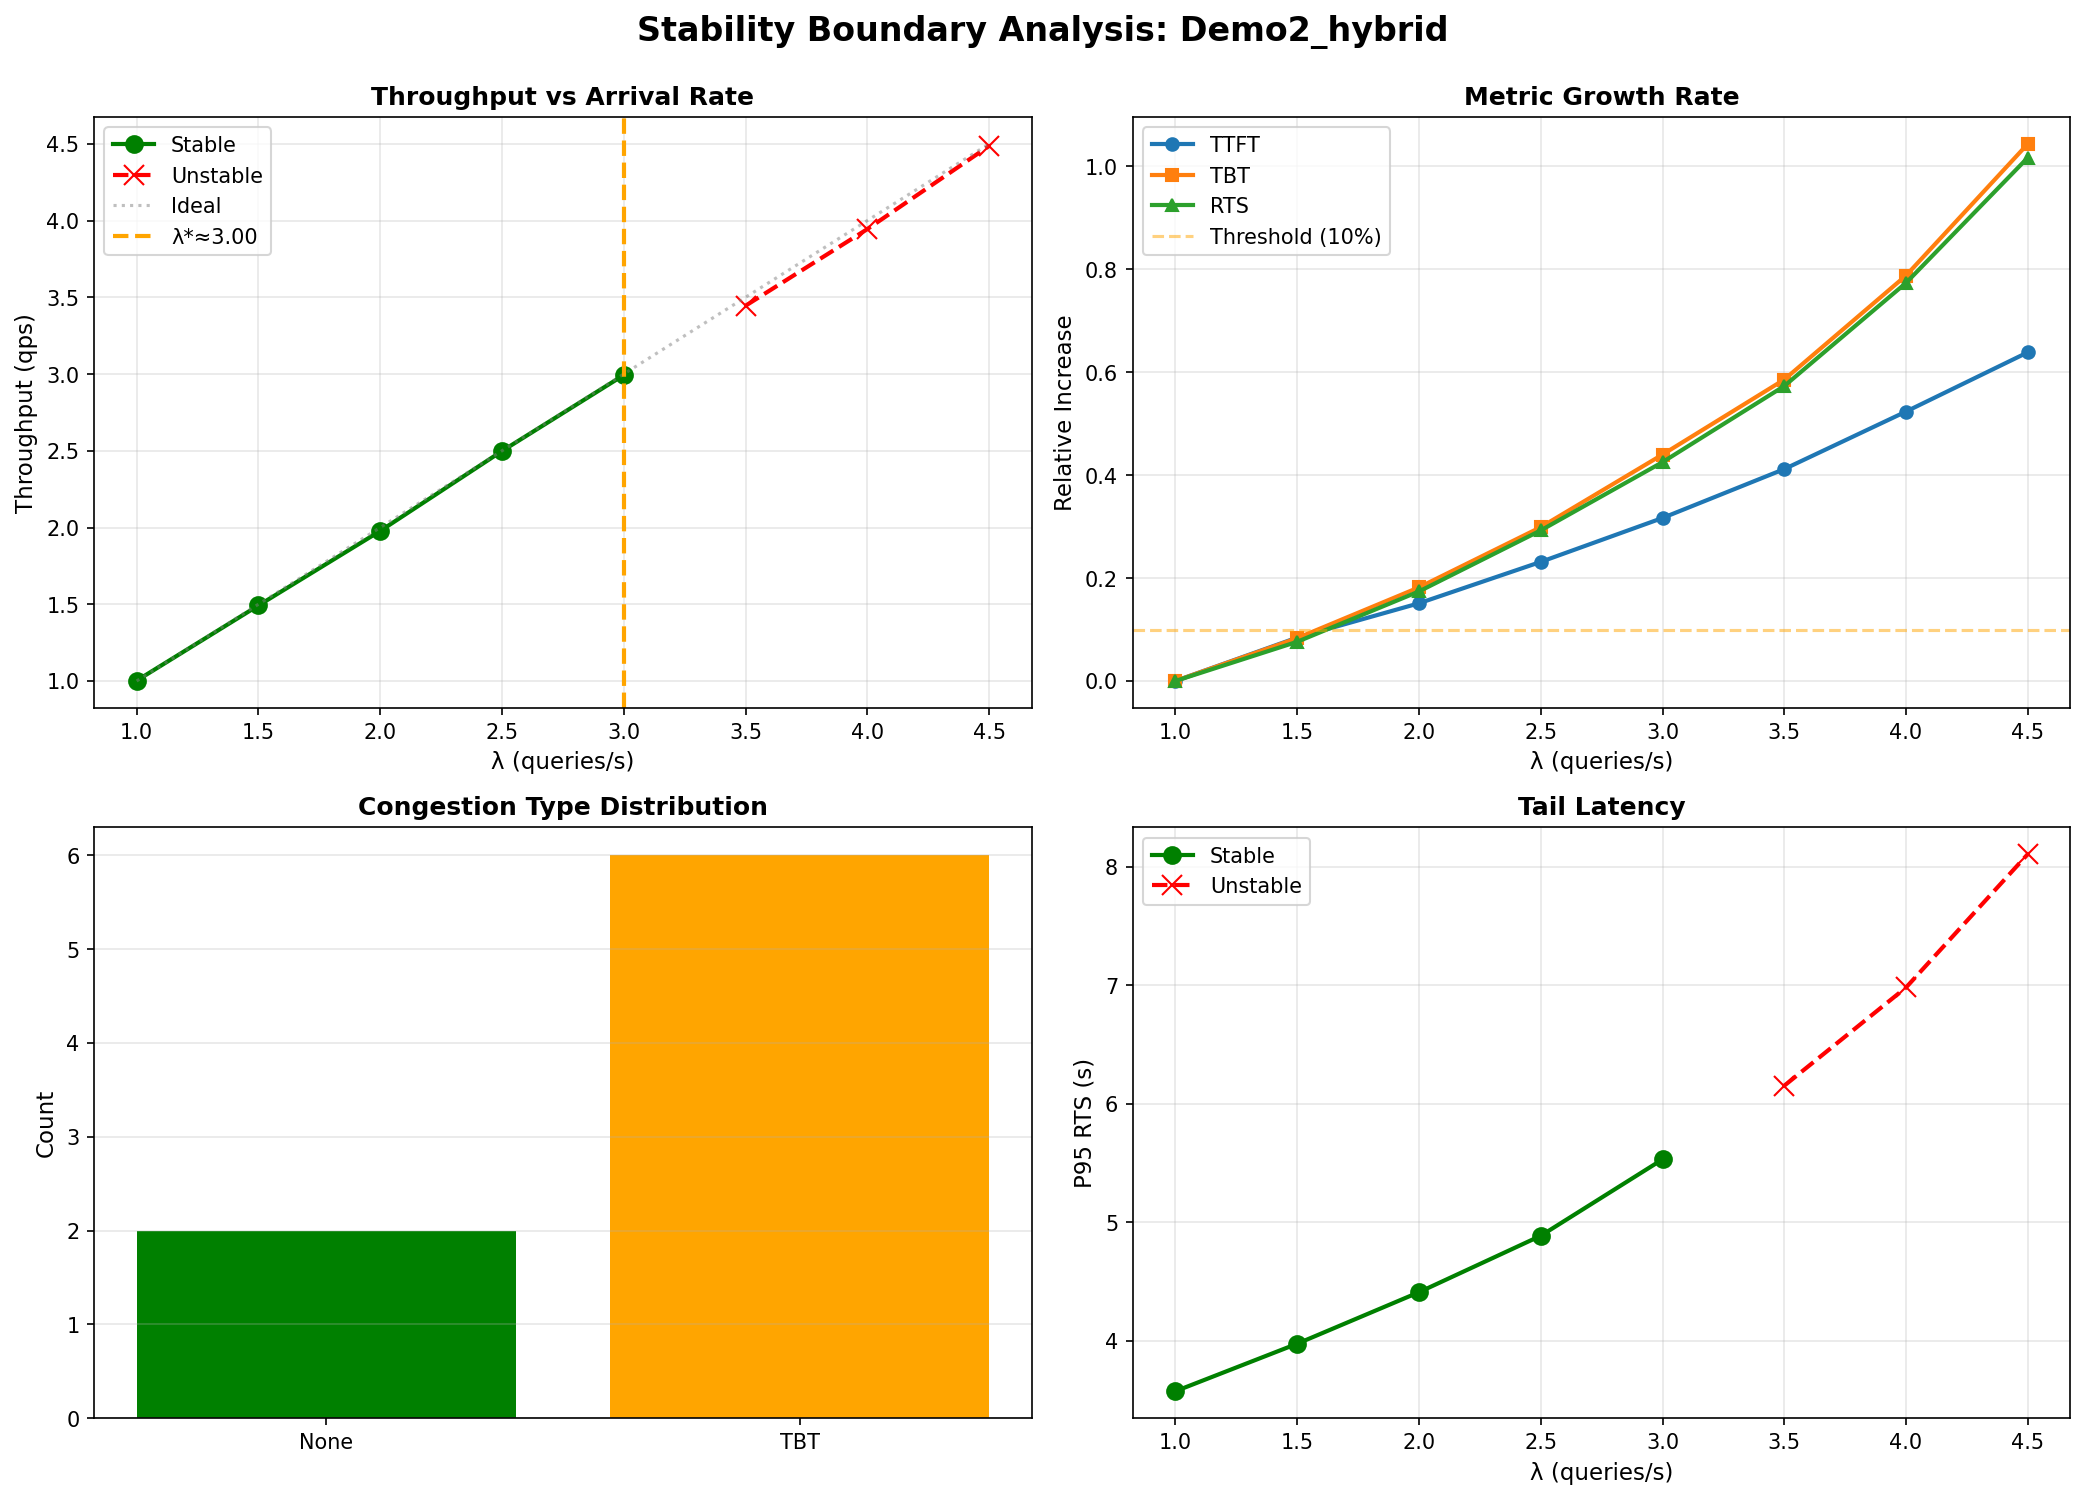


Scheduler Comparison:


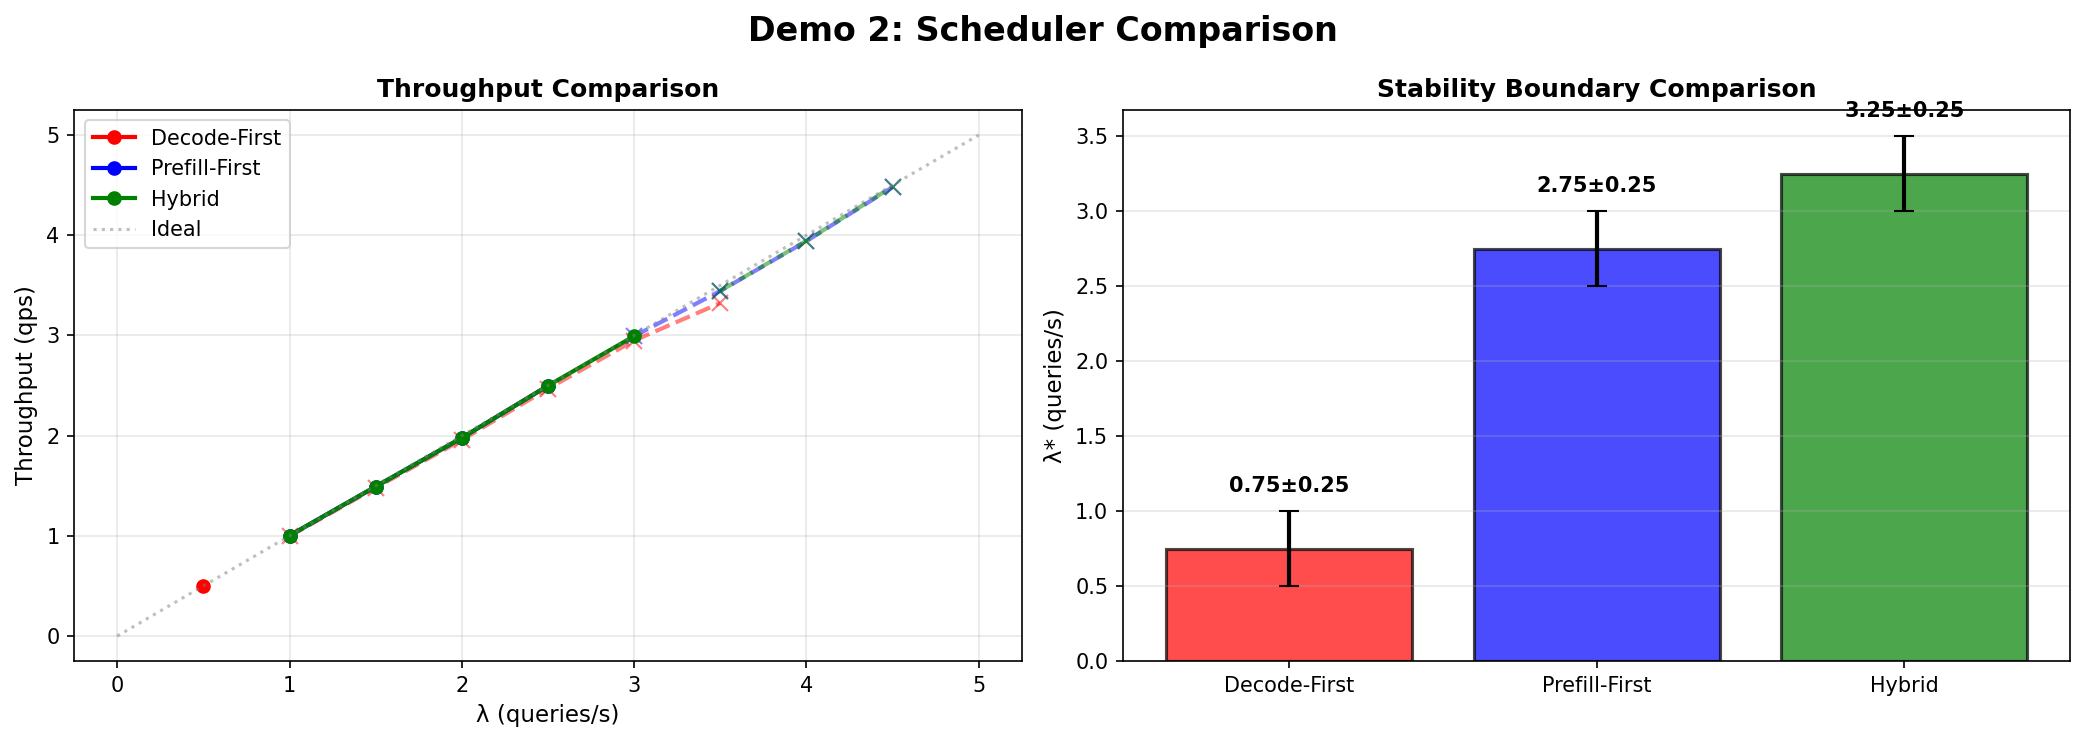

In [7]:

from IPython.display import Image, display



for scheduler in ['decode_prioritizing', 'prefill_prioritizing', 'hybrid']:
    filename = f'figs/Demo2_{scheduler}_stability_boundary.png'
    if os.path.exists(filename):
        print(f"\n{scheduler}:")
        display(Image(filename=filename, width=900))


filename = 'figs/Demo2_comparison.png'
if os.path.exists(filename):
    print("\nScheduler Comparison:")
    display(Image(filename=filename, width=900))

Congestion type distribution plot

Loaded decode_prioritizing: 7 points
Loaded hybrid: 8 points
Loaded prefill_prioritizing: 8 points


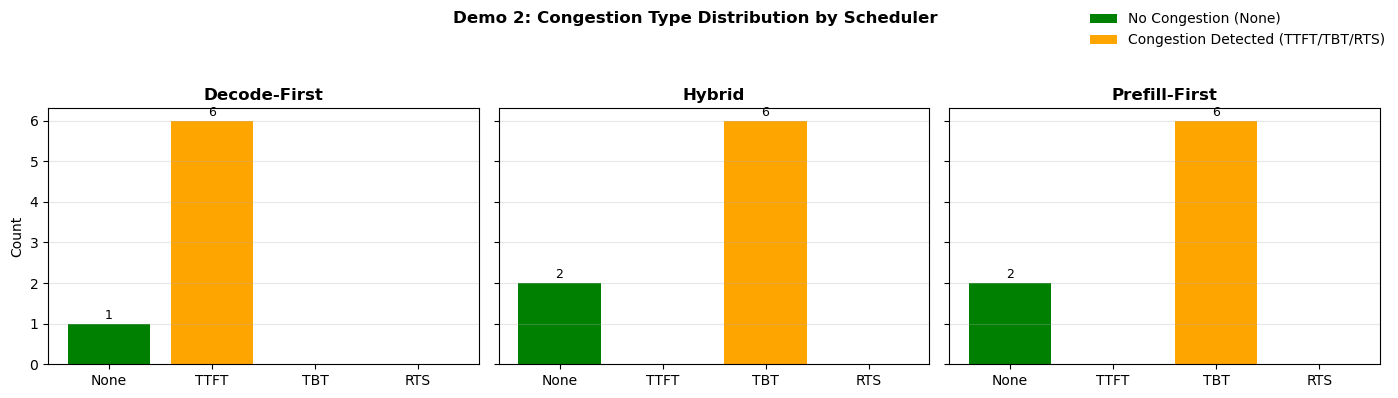

Saved: figs/Demo2_congestion_subplots.png


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Patch


COLOR_NONE = "green"
COLOR_CONGESTED = "orange"   

def compute_congestion_counts(results_df, threshold=0.10):
 
    ttft = results_df["TTFT_Avg"].values
    tbt  = results_df["TBT_Avg"].values
    rts  = results_df["RTS_Avg"].values

    ttft_inc = (ttft - ttft[0]) / (ttft[0] + 1e-9)
    tbt_inc  = (tbt  - tbt[0])  / (tbt[0]  + 1e-9)
    rts_inc  = (rts  - rts[0])  / (rts[0]  + 1e-9)

    types = []
    for i in range(len(results_df)):
        inc = {"TTFT": ttft_inc[i], "TBT": tbt_inc[i], "RTS": rts_inc[i]}
        if max(inc.values()) > threshold:
            types.append(max(inc, key=inc.get))
        else:
            types.append("None")

    return Counter(types)

def plot_demo2_congestion_subplots(threshold=0.10, out_path="figs/Demo2_congestion_subplots.png"):
   
    schedulers = [
        ("decode_prioritizing",  "Decode-First"),
        ("hybrid",               "Hybrid"),
        ("prefill_prioritizing", "Prefill-First"),
    ]


    categories = ["None", "TTFT", "TBT", "RTS"]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
    fig.suptitle("Demo 2: Congestion Type Distribution by Scheduler", fontweight="bold")

    for ax, (sch, title) in zip(axes, schedulers):
        df = load_scheduler_data(sch)  

        ax.set_title(title, fontweight="bold")
        ax.grid(True, axis="y", alpha=0.3)

        if df is None or len(df) == 0:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks(range(len(categories)))
            ax.set_xticklabels(categories)
            continue

        cnt = compute_congestion_counts(df, threshold=threshold)
        y = [cnt.get(cat, 0) for cat in categories]


        colors = [COLOR_NONE if cat == "None" else COLOR_CONGESTED for cat in categories]

        bars = ax.bar(categories, y, color=colors)

     
        for b in bars:
            v = b.get_height()
            if v > 0:
                ax.text(
                    b.get_x() + b.get_width() / 2,
                    v + 0.05,
                    f"{int(v)}",
                    ha="center",
                    va="bottom",
                    fontsize=9
                )

    axes[0].set_ylabel("Count")


    legend_elements = [
        Patch(facecolor=COLOR_NONE, label="No Congestion (None)"),
        Patch(facecolor=COLOR_CONGESTED, label="Congestion Detected (TTFT/TBT/RTS)"),
    ]
    fig.legend(handles=legend_elements, loc="upper right", frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")


plot_demo2_congestion_subplots(threshold=0.10)


Metric growth rate comparison

Loaded decode_prioritizing: 7 points
Loaded hybrid: 8 points
Loaded prefill_prioritizing: 8 points


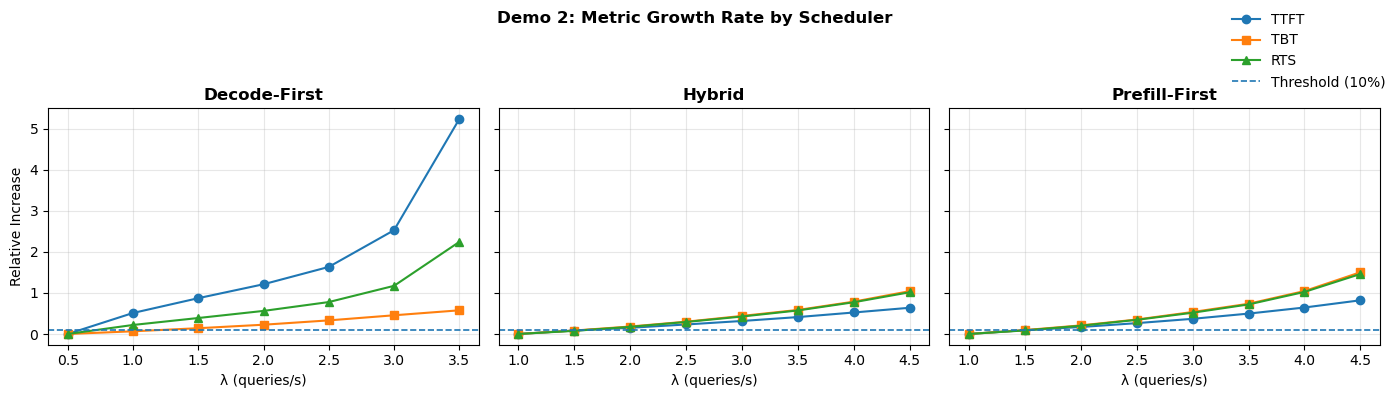

Saved: figs/Demo2_metric_growth_rate_subplots.png


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

def _get_lambda_col(df):
    for c in ["lambda", "Lambda", "lam", "arrival_rate", "arrival", "rate"]:
        if c in df.columns:
            return c
    raise KeyError(f"Cannot find lambda column. Available columns: {list(df.columns)}")

def compute_metric_growth(df):
   
    lam_col = _get_lambda_col(df)
    df = df.sort_values(lam_col).reset_index(drop=True)

    lam = df[lam_col].to_numpy(dtype=float)
    ttft = df["TTFT_Avg"].to_numpy(dtype=float)
    tbt  = df["TBT_Avg"].to_numpy(dtype=float)
    rts  = df["RTS_Avg"].to_numpy(dtype=float)

    ttft_g = (ttft - ttft[0]) / (ttft[0] + 1e-9)
    tbt_g  = (tbt  - tbt[0])  / (tbt[0]  + 1e-9)
    rts_g  = (rts  - rts[0])  / (rts[0]  + 1e-9)

    return lam, ttft_g, tbt_g, rts_g

def plot_demo2_metric_growth_rate_subplots(threshold=0.10,
                                          out_path="figs/Demo2_metric_growth_rate_subplots.png"):
    schedulers = [
        ("decode_prioritizing",  "Decode-First"),
        ("hybrid",               "Hybrid"),
        ("prefill_prioritizing", "Prefill-First"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
    fig.suptitle("Demo 2: Metric Growth Rate by Scheduler", fontweight="bold")

    for ax, (sch, title) in zip(axes, schedulers):
        df = load_scheduler_data(sch)   

        ax.set_title(title, fontweight="bold")
        ax.grid(True, alpha=0.3)

        if df is None or len(df) == 0:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", transform=ax.transAxes)
            continue

        lam, ttft_g, tbt_g, rts_g = compute_metric_growth(df)

       
        ax.plot(lam, ttft_g, marker="o", label="TTFT")
        ax.plot(lam, tbt_g,  marker="s", label="TBT")
        ax.plot(lam, rts_g,  marker="^", label="RTS")


        ax.axhline(threshold, linestyle="--", linewidth=1.2, label=f"Threshold ({int(threshold*100)}%)")

        ax.set_xlabel("λ (queries/s)")

    axes[0].set_ylabel("Relative Increase")

    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")

plot_demo2_metric_growth_rate_subplots(threshold=0.10)
